# MNIST Handwriten Digits Classifier

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model_root_dir = '/notebooks/my-notebooks/MNIST/'
model_logdir = model_root_dir+'logdir/'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=True)

Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
image_size = 28
num_classes = 10

LABELS = os.path.join(os.getcwd(), model_logdir+"labels_1024.tsv")
SPRITES = os.path.join(os.getcwd(), model_logdir+"sprite_1024.png")

In [5]:
batch_size = 100
learning_rate = 0.5
iterations = 1001

In [6]:
hparam_str = 'fc1,lr_%f' % (learning_rate)
previous_runs = list(f for f in os.listdir(model_logdir) if f.startswith('run'))

if len(previous_runs) == 0:
    run_number = 1  
else:
    run_number = max([int(s[4:6]) for s in previous_runs]) + 1

LOGDIR = '%srun_%02d,' % (model_logdir, run_number)+hparam_str

In [7]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [8]:
X_placeholder = tf.placeholder(shape=[None, image_size**2], dtype=tf.float32, name='X_placeholder')
Y_placeholder = tf.placeholder(shape=[None, num_classes], dtype=tf.int64, name='Y_placeholder')

X_image = tf.reshape(X_placeholder, shape=[-1,28,28, 1])
tf.summary.image('input', X_image, 3)

<tf.Tensor 'input:0' shape=() dtype=string>

In [9]:
with tf.name_scope('layer_1'):

    W = tf.Variable(np.zeros([image_size**2, num_classes]), dtype=tf.float32, name='W')
    b = tf.Variable(np.ones(shape=[num_classes]), dtype=tf.float32, name='b')

    tf.summary.histogram('Weights', W)
    tf.summary.histogram('bias', b)

In [10]:
with tf.name_scope('predictions'):

    Y_prediction = tf.matmul(X_placeholder, W) + b
    
    tf.summary.histogram('Predictions', Y_prediction)
    
    embedding_input = Y_prediction
    
    embedding_size = num_classes

In [11]:
with tf.name_scope('loss'):

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_placeholder, logits=Y_prediction, name='loss'))

    tf.summary.scalar('loss', loss)

with tf.name_scope('train'):

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [12]:
with tf.name_scope('accuracy'):
    
    correct_prediction = tf.equal(tf.argmax(Y_prediction, 1), tf.argmax(Y_placeholder, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.summary.scalar('accuracy', accuracy)

In [13]:
summ = tf.summary.merge_all()

embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="test_embedding")
assignment = embedding.assign(embedding_input)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)

config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
embedding_config = config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.sprite.image_path = SPRITES
embedding_config.metadata_path = LABELS
embedding_config.sprite.single_image_dim.extend([image_size, image_size])
tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

In [14]:
losses = np.array([])

for idx in range(iterations):
    
    batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=True)
    
    _, _loss, _summary = sess.run([train_step, loss, summ], 
                        feed_dict={
                            X_placeholder: batch_xs,
                            Y_placeholder: batch_ys
                        })
    
    if idx % (iterations/20) == 0:

        _accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.validation.images,
                                                  Y_placeholder : mnist.validation.labels
                                                 })
        
        print 'step', idx, 'loss', np.mean(_loss), 'accuracy', str(round(100*_accuracy,2))+'%'
    
    if idx % 20 == 0:
        writer.add_summary(_summary, idx)
        
    if idx % 500 == 0:
        sess.run(assignment, feed_dict={X_placeholder: mnist.test.images[:1024], Y_placeholder: mnist.test.labels[:1024]})
        saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), idx)
        
    losses = np.append(losses, np.mean(_loss))
    

step 0 loss 2.3025851 accuracy 53.36%
step 50 loss 0.46202508 accuracy 87.9%
step 100 loss 0.39401966 accuracy 89.76%
step 150 loss 0.45707196 accuracy 90.04%
step 200 loss 0.45958462 accuracy 90.74%
step 250 loss 0.25583693 accuracy 90.96%
step 300 loss 0.31530276 accuracy 91.32%
step 350 loss 0.32266328 accuracy 91.16%
step 400 loss 0.26008263 accuracy 91.38%
step 450 loss 0.3954101 accuracy 91.56%
step 500 loss 0.37410873 accuracy 91.2%
step 550 loss 0.35309425 accuracy 91.86%
step 600 loss 0.19518854 accuracy 91.8%
step 650 loss 0.19663091 accuracy 91.72%
step 700 loss 0.34702012 accuracy 91.7%
step 750 loss 0.22632591 accuracy 91.66%
step 800 loss 0.288632 accuracy 91.84%
step 850 loss 0.33109555 accuracy 91.8%
step 900 loss 0.22720376 accuracy 91.88%
step 950 loss 0.41298208 accuracy 91.88%
step 1000 loss 0.29678628 accuracy 91.98%


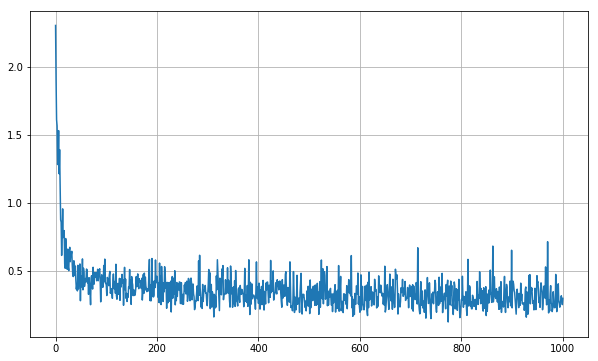

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

In [16]:
_accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.test.images,
                                          Y_placeholder : mnist.test.labels
                                         })

print str(round(100*_accuracy,2))+'%'

91.56%
